### Feature Importance

Feature Importance is a process used to select features in the dataset that contributes the most in predicting the target variable. Working with selected features instead of all the features reduces the risk of over-fitting, improves accuracy, and decreases the training time.

Finding Feature importance and selecting top 8 features


In [41]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn import model_selection
import seaborn as sns
from sklearn import metrics

In [38]:
def threshhold_and_plot(y_test, target, n_points=50, plot=True):
    """
    :param y_test: binary vector of actual targets
    :param target: vector of probabilities
    :param n_points: number of points to evaluate for a threshold
    :param plot: Boolean; whether or not to plot the results
    :return: vector of values of precision, recall, F1 for given points
    """
    # plot the value of the metric against the threshold
    #plt.figure(figsize=(12,12))
    probs = np.linspace(0, 1, n_points)
    def make_thresh():  # try n_points = 50 or 100...
        # calculate each metric here
        precision = [metrics.precision_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                     for thresh in probs]
        recall = [metrics.recall_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                  for thresh in probs]
        f1 = [metrics.f1_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
              for thresh in probs]
        roc_auc = [metrics.roc_auc_score(y_test,np.where(target > thresh,1,0))
                   for thresh in probs]
       
        return precision, recall, f1, roc_auc

    precision, recall, f1, roc_auc = make_thresh()

    
    if plot:
        plt.plot(probs, precision, label='precision')
        plt.plot(probs, recall, label='recall')
        plt.plot(probs, f1, label='f1')
        plt.plot(probs, roc_auc, label="roc auc")
        # plt.plot(probs, pr_auc, label="pr auc")
        plt.title("Metrics at various thresholds");
        plt.xlabel("Probability");
        plt.legend();
        return precision, recall, f1, roc_auc
    else:
        return precision, recall, f1, roc_auc

def max_thresh(score_vec):
  # can either unpack a tuple or feed in iterable by itself
    max_idx = np.argmax(score_vec)
    max_score = score_vec[max_idx]
    return max_idx, max_score

In [48]:
def plot_Confusionmatrix(actuals,target):
    plt.figure(figsize=(5,4))
    ConfMatrix = metrics.confusion_matrix(actuals,target, labels=[0,1], normalize='true')
    
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", 
                xticklabels = ["Staying","Attrited"], 
                yticklabels = ["Staying","Attrited"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix");
    return

In [3]:
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

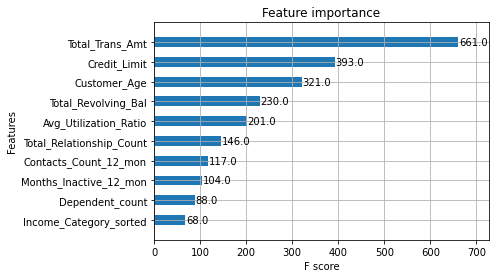

<Figure size 1440x1440 with 0 Axes>

['Total_Revolving_Bal', 0.18961056]
['Total_Trans_Amt', 0.14141884]
['Total_Relationship_Count', 0.1392616]
['Months_Inactive_12_mon', 0.08161943]
['Gender_Encoded', 0.07091206]
['Customer_Age', 0.063494116]
['Contacts_Count_12_mon', 0.050714638]
['Credit_Limit', 0.045570944]
['Marital_Status_sorted_Married', 0.045564655]
['Dependent_count', 0.03548129]
['Avg_Utilization_Ratio', 0.034051042]
['Marital_Status_sorted_Single', 0.02745477]
['Education_Level_sorted', 0.025964404]
['Income_Category_sorted', 0.024694106]
['Card_Category_sorted', 0.024187576]
['Months_on_book', 0.0]


In [6]:
#find top 8 feature using XGBoost, using built in XGB 

from xgboost import XGBRegressor,plot_importance
import matplotlib.pyplot as plt
#xgb = XGBRegressor(n_estimators=100)
xgb = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)
xgb.fit(X_train, y_train)

# from Builtin XGB
plot_importance(xgb, max_num_features = 10,height=0.5)
plt.figure(figsize=(20,20))
plt.show()

sorted_idx = np.argsort(xgb.feature_importances_)[::-1]
for index in sorted_idx:
   print([X_train.columns[index], xgb.feature_importances_[index]])

### Feature interactions

For this purpose I am using python package called 'patsy'. And here is the intoduction and references.

Feature interaction using design Matrix. The design matrix contains data on the independent variables (also called explanatory variables) in statistical models which attempt to explain observed data on a response variable (often called a dependent variable) in terms of the explanatory variables. The theory relating to such models makes substantial use of matrix manipulations involving the design matrix: see for example linear regression. A notable feature of the concept of a design matrix is that it is able to represent a number of different experimental designs and statistical models, e.g., ANOVA, ANCOVA, and linear regression.[ ref: https://en.wikipedia.org/wiki/Design_matrix

ref:

    https://learn-scikit.oneoffcoder.com/patsy.html
    https://learn-scikit.oneoffcoder.com/xgboost.html
    https://readthedocs.org/projects/patsy/downloads/pdf/latest/
    https://www.programcreek.com/python/example/120751/patsy.dmatrix

patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S. For instance, if we have some variable y, and we want to regress it against some other variables x, a, b, and the interaction of a and b, then we simply write: patsy.dmatrices("y ~ x + a + b + a:b", data) and Patsy takes care of building appropriate matrices. ref: https://patsy.readthedocs.io/en/latest/overview.html

Patsy is a neat API to transform your data into experimentation model form. For regression and classification problems, you often want your data in the Xy form where X is a matrix (independent variable) and y is a column vector (dependent variable). ref: https://learn-scikit.oneoffcoder.com/patsy.html


In [8]:
from patsy import dmatrix
#formula = 'Customer_Age*Credit_Limit*Total_Revolving_Bal*Total_Trans_Amt*Avg_Utilization_Ratio*Total_Relationship_Count*Contacts_Count_12_mon*Months_Inactive_12_mon'
# only top 5 is used.
#create model formula
model_formula = 'Total_Trans_Amt*Credit_Limit*Customer_Age*Total_Revolving_Bal*Avg_Utilization_Ratio'
#Apply model formula to train and test
X_train_f = dmatrix(model_formula, X_train, return_type='dataframe')
X_test_f = dmatrix(model_formula, X_test, return_type='dataframe')

In [9]:
X_train.head(5)

,Customer_Age,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Avg_Utilization_Ratio,Gender_Encoded,Dependent_count,Education_Level_sorted,Income_Category_sorted,Card_Category_sorted,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Marital_Status_sorted_Married,Marital_Status_sorted_Single
0,-0.536671,10.312845,1.672427,8.978408,0.071,0,3,3,3,1,-0.536671,1,1,2,1,0
1,-0.536671,8.285009,0.956795,8.429454,0.307,1,2,2,1,1,-0.536671,3,5,2,1,0
2,-0.038008,7.555905,0.920660,8.484877,0.613,1,4,3,2,1,-0.038008,6,4,2,1,0
3,-1.284665,9.568294,0.549097,8.465057,0.049,1,2,1,1,1,-1.284665,3,2,1,0,0
4,1.582646,8.352554,0.000000,7.494430,0.000,0,0,3,2,1,1.582646,3,2,3,1,0


In [17]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    #pipeline
    clf_pipeline = Pipeline([("clf",model)])
    #Grid search CV
    scoring = 'roc_auc'
    verbose = 1
    clf_rand = model_selection.RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    #Learn from training
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

In [18]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [25]:
%%time
classifier = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train_f,y_train, xgb_params,classifier,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.4, 'clf__min_child_weight': 2, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}

Best train roc_auc score: 0.95
Wall time: 4min 40s


In [27]:
%%time
cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))
cv_scores_xgb = (
  model_selection.cross_val_score(xgb_best_estimator,
                                  X_train_f,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 31.8 s


In [29]:
cv_quantiles = np.quantile(a=cv_scores_xgb,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{cv_scores_xgb.mean():.3f}")

 Performance on training set is in range between 0.942 to 0.965,with average roc_auc:0.955


<AxesSubplot:ylabel='Count'>

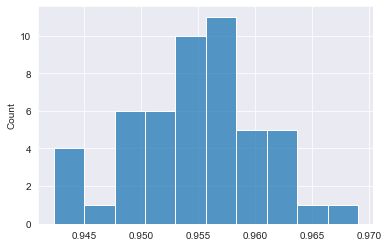

In [33]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_xgb, bins=10)

### Get threshold using train set

In [36]:
#use train data to get threshold for roc_auc
y_proba_xgb = xgb_best_estimator.predict_proba(X_train_f)
y_proba_xgb = y_proba_xgb[:,1]

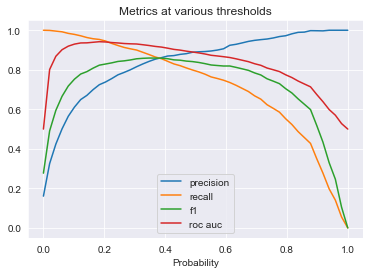

In [42]:
xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = threshhold_and_plot(y_train,y_proba_xgb)

In [43]:
xgb_thresh_idx, xgb_max_score = max_thresh(xgb_roc_auc)
print(f'max_roc_auc is: {xgb_max_score}')

max_roc_auc is: 0.942022260918126


### Apply threshold on train set

In [46]:
xgb_train_labels = np.where(y_proba_xgb >= xgb_max_score, 1, 0)

classification report
               precision    recall  f1-score   support

     Staying       0.87      1.00      0.93      5949
    Attrited       1.00      0.19      0.32      1139

    accuracy                           0.87      7088
   macro avg       0.93      0.59      0.62      7088
weighted avg       0.89      0.87      0.83      7088



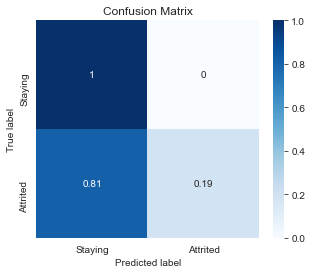

In [49]:
plot_Confusionmatrix(y_train,xgb_train_labels)
y_class_report = metrics.classification_report(y_train,xgb_train_labels,zero_division=1, target_names=["Staying","Attrited"])
print("classification report\n", y_class_report )

### Apply threshold on test set

In [52]:
xgb_test_predict = xgb_best_estimator.predict_proba(X_test_f)

In [53]:
xgb_test_labels = np.where(xgb_test_predict[:,1] >= xgb_max_score, 1, 0)

classification report
               precision    recall  f1-score   support

     Staying       0.86      1.00      0.93      2551
    Attrited       0.96      0.17      0.29       488

    accuracy                           0.87      3039
   macro avg       0.91      0.58      0.61      3039
weighted avg       0.88      0.87      0.82      3039



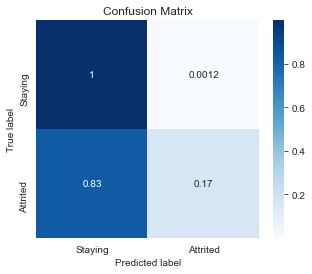

In [54]:
plot_Confusionmatrix(y_test,xgb_test_labels)
y_class_report = metrics.classification_report(y_test,xgb_test_labels,zero_division=1, target_names=["Staying","Attrited"])
print("classification report\n", y_class_report )

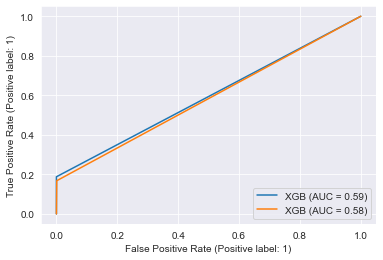

In [55]:
#roc_auc
fig = metrics.RocCurveDisplay.from_predictions(y_train, xgb_train_labels,name='XGB')
fig = metrics.RocCurveDisplay.from_predictions(y_test, xgb_test_labels, ax = fig.ax_,name='XGB')
plt.show()

Not much of improvement with feature interactions. selected top 8 features so rest of the features are not influencing. 